# Lab 05: Wine Quality

---
author: Brady Brooks
date: October 5, 2024
embed-resources: true
---

## Introduction

In this report, I develop a model to predict the quality of wine based on characteristics and physicochemical data. Specifically, I want to develop a model to predict the wine quality instead of hiring a sommelier. Using the physicochemical data, I created a regression model using a pipeline with Linear Regression, KNeighbors, and Hist Gradient Boost.

## Methods

In [40]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import warnings

### Data

In [41]:
# load data
wine_train = pd.read_csv("https://cs307.org/lab-05/data/wine-train.csv")
wine_test = pd.read_csv("https://cs307.org/lab-05/data/wine-test.csv")
wine_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
3,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
4153,9.2,0.58,0.20,3.0,0.081,15.0,115.0,0.99800,3.23,0.59,9.5,5,red
4154,8.2,0.60,0.17,2.3,0.072,11.0,73.0,0.99630,3.20,0.45,9.3,5,red
4155,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5,white


The data was collected from UC Irvine Machine Learning Repository but the original source is: 

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision support systems, 47(4), 547-553. https://doi.org/10.1016/j.dss.2009.05.016

Each observation contains the quality of a wine rated by sommeliers and physicochemical data.

##### Response

Quality
-   [int64] the quality of the wine based on evaluation by a minimum of three sensory assessors (using blind tastes), which graded the wine in a scale that ranges from 0 (very bad) to 10 (excellent)


##### Features

Color
-   [object] color of the wine (Red or White)

Fixed Acidity
-   [float64] grams of tartaric acid per cubic decimeter

Volatile Acidity
-   [float64] grams of acetic acid per cubic decimeter

Citric Acud
-   [float64] grams of citric acid per cubic decimeter

Residual Sugar
-   [object] grams of residual sugar per cubic decimeter

Chlorides
-   [float64] grams of chlorides per cubic decimeter

Free Sulfer Dioxide
-   [float64] milligrams of free sulfur dioxide per cubic decimeter

Total Sulfur Dioxide
-   [float64] milligrams of total sulfur dioxide per cubic decimeter
 
Density
-   [float64] the total density of the wine in grams per cubic centimeter

pH
-   [object] the acidity of the wine measured using pH

Sulphates
-   [object] grams of potassium sulphate cubic decimeter

Alcohol
-   [float64] percent alcohol by volume

In [42]:
# summary statistics
wine_train.shape

(4157, 13)

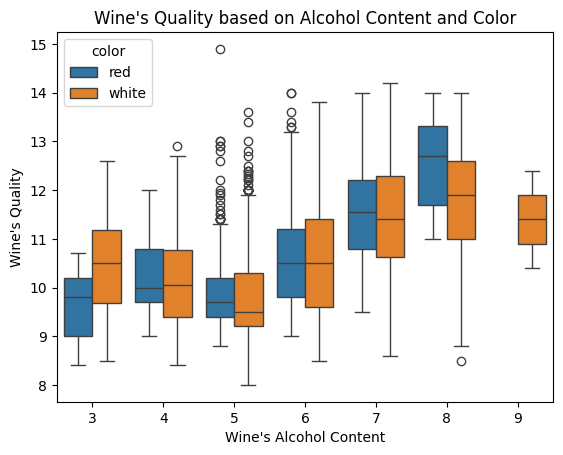

In [43]:
# visualizations
sns.boxplot(data=wine_train, x='quality', y='alcohol', hue="color")
plt.title("Wine's Quality based on Alcohol Content and Color")
plt.xlabel("Wine's Alcohol Content")
plt.ylabel("Wine's Quality")
plt.show()

The above visualization shows that the alcohol content in wine is correlated with the quality of the wine. In addition, we can see that color isn't as highly correlated with the quality as the alcohol content is. The color is consistent for the most part with one another.

### Models

In [44]:
# process data for ML
# create X and y for train
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

In [45]:
# train models
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# pipeline for numeric
numeric_preprocessor = Pipeline(steps=[
    ("MedianImputer", SimpleImputer(strategy="median")), 
    ("Standardize", StandardScaler()),
    ])
# pipeline for categorical
categorical_preprocessor = Pipeline(steps=[
    ("ModelImputer", SimpleImputer(strategy="most_frequent")), 
    ("OneHotEncoder", OneHotEncoder(handle_unknown="ignore")),
    ])
# column transformer 
preprocessor = ColumnTransformer([
    ("NumericProcessing", numeric_preprocessor, numeric_features),
    ("CategoricalProcessing", categorical_preprocessor, categorical_features),
])
# full pipeline
pipeline = Pipeline(steps=[
    ("Preprocessor", preprocessor),
    ("Regressor", LinearRegression())
])

In [54]:
param_grid = [ 
    {"Regressor": [LinearRegression()],
     "Regressor__fit_intercept":  [False, True]},
    {"Regressor": [KNeighborsRegressor()],
    "Preprocessor__CategoricalProcessing__OneHotEncoder__drop": [None, "first"],
    "Regressor__n_neighbors": range(5,20,1),
    "Regressor__metric": ["euclidean", "manhattan"]},
    {"Regressor": [HistGradientBoostingRegressor()],
        "Regressor__learning_rate": [0.1, 0.01, 0.001],
        "Regressor__max_iter": [1000],
        "Regressor__max_depth": [None, 3],
        "Regressor__l2_regularization": [0.1,1.0],
    }
]

In [ ]:
warnings.filterwarnings("ignore")
mod = GridSearchCV(pipeline, param_grid = param_grid, n_jobs=-1, cv=5, verbose=3, scoring="neg_mean_absolute_error")
_ = mod.fit(X_train, y_train)

To develop a model, I tuned a Linear Regression, KNeighbors, and Hist Gradient Boosting model. For the linear regression, I tested both with an intercept and without one. For KNeighbors, I tested a k of 5 to 20, and numerous metrics such as manhattan distance and euclidean distance. Lastly, for Hisogram Gradient Boosting I tested numerous learning rates, max depth, and more.

## Results

In [56]:
# report model metrics
mod.best_params_

{'Regressor': HistGradientBoostingRegressor(),
 'Regressor__l2_regularization': 0.1,
 'Regressor__learning_rate': 0.1,
 'Regressor__max_depth': None,
 'Regressor__max_iter': 1000}

Of all the models considered, Histogram Gradient Boosting with a l2 regularization of 0.1, a learning rate of 0.1, and no max depth achieved the lowest mean absolute error (MAE). We will consider this model going forward.

In [57]:
-mod.best_score_

np.float64(0.4779188339020678)

This histogram gradient boosting model achieced a test MAE of 0.4779188339020678.

## Discussion

Depending on the cost of the chemistry equipment and the time needed to produce results verses the a human will dictate the use of this model in practice. Although it's mean average error is pretty low and is likely to predict a wine's quality within 1, the AI cannot replace all aspects of a sommelier. Even though it can predict the quality of the wine, it cannot tell us what good food pairing are with the wine. Given that this is one of the main roles of a sommelier, it would still be worth it to hire one instead of continuing to conduct experiments and only predicting the wine's quality.

The model I have developed is a regression modeel and is predictig floats. Even though the target variable is an integer from 0-10, the model predicts a float. This isn't a problem because the mean average error is less than 0.5 so which ever integer the float is closest to, is likely the wine's quality. This model may be improved if we test more tuning parameters for regression or if we were to try classification. 

### Conclusion

Given the above, I would elect to not consider using this model in practice. Although the model is pretty accurate, it does not achieve all the goals we are looking for than a sommelier would. This model could also be improved by using classification instead of regession. Overall, I believe it is best to just hire a sommelier as provides all the benefits of one and it doesn't require the use of chemical equipment.

In [50]:
from joblib import dump
dump(mod, "wine-quality.joblib")

['wine-quality.joblib']